Support algs imported!
1.2205958366394043


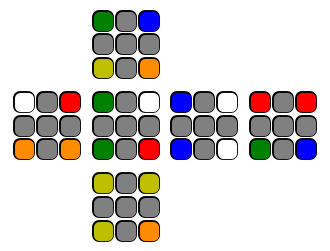

Cube initiated
Gripbased alg genning initiated
--- Initiating alg genning up to length 6 ---
Parameters:
  - mode = 2
  - start_grips = 1
  - skip_U = True
  - prnt = False
--- Initiating search alg genning up to length 3. Previous algs cannot be reused if we want to follow the table ---
--- Done generating algs ---
  - Total time spent: 3.98 seconds.
  - Alg count: 0.
--- Initiating alg categorization ---
--- Done categorizing algs ---
--- Statistics ---
  - Average alg length: 0.00 (0.00 variance)
  - Best case: 100 moves
  - Worst case: 0 moves
Further processing may be necessary.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import time
import random

%run gripbased.ipynb
full_algs = gen_full_algs(length=6, mode=2, move_transition=move_transition, start_grips=np.array([1]), skip_U=True, prnt=False, categorize=True, categorize_mode=0, return_full_alg_list=True)

In [2]:
move_transition_CPFB = np.array([ 
#   [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44],
    [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#   [ R,R2,R', L,L2,L', r,r2,r', l,l2,l', M,M2,M', U,U2,U', D,D2,D', u,u2,u', d,d2,d', E,E2,E', F,F2,F', B,B2,B', f,f2,f', b,b2,b', S,S2,S'],
    [ 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 1, 1], # 1. Standard
    [ 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2], # 2. After F
])

In [3]:
move_transition_scramble = np.array([ 
#   [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44],
    [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#   [ R,R2,R', L,L2,L', r,r2,r', l,l2,l', M,M2,M', U,U2,U', D,D2,D', u,u2,u', d,d2,d', E,E2,E', F,F2,F', B,B2,B', f,f2,f', b,b2,b', S,S2,S'],
    [ 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 1. Standard
])

def random_scramble_from_move_transition(move_transition, length=20, grips = np.array([1]), force_start = -1, string_scramble = False):
    scramble = - np.ones(length, dtype = np.int8) # -1 is the null move
    last_move = -1
    if force_start != -1:
        move = force_start
    for i in range(length):
        grips = move_transition[grips, move]
        scramble[i] = move
        last_move = move
        moves = get_valid_moves_list(grips, last_move, move_transition = move_transition)
        move = random.choice(moves)
    if string_scramble:
        scramble = array_to_alg(scramble)
    return scramble

In [4]:
def get_all_2gen_IDs():
    cube = Cube(4)
    IDs = []
    while len(IDs)<120:
        # apply random R or U move, get ID, and check if it's new and if so add it to the list
        move = random.choice(["R","U"])
        cube.apply_moves(move)
        ID = id_from_state(cube.state)
        if ID not in IDs:
            IDs.append(ID)
    return IDs

ids_2gen = get_all_2gen_IDs()

def CP_solver_setup(mode, search_depth, table_depth, move_transition=move_transition, start_grips=np.array([1]), skip_U=True, prnt=True):
    # generate search algorithms and a table for a given mode, search_depth, table_depth, and move_transition matrix
    start_grips_table = (np.array(range(len(move_transition)))+1)[:-1]
    search_algs = gen_algs_cumulative(max_length = table_depth, start_grips = start_grips_table, move_transition = move_transition, prnt = prnt)
    table = gen_table(search_algs, mode, skip_U, prnt)
    search_algs = gen_algs_cumulative(max_length = search_depth, start_grips = start_grips, move_transition = move_transition, prnt = prnt)
    return search_algs, table

mode = 22
search_depth = 3
table_depth = 3
search_algs_CPFB, table_CPFB = CP_solver_setup(mode, search_depth, table_depth, move_transition=move_transition_CPFB, start_grips=np.array([1]), skip_U=True, prnt=True)

Genning search algs...
Algs of length 1 genned. Time spent: 0.00s...
Algs of length 2 genned. Time spent: 0.00s...
Algs of length 3 genned. Time spent: 0.00s...
Done genning algs. Making into np array. Time spent: 0.00s
Genning table based on 4666 algs...
466 (9.99%) algs added in 0.01 seconds...
932 (19.97%) algs added in 0.01 seconds...
1398 (29.96%) algs added in 0.02 seconds...
1864 (39.95%) algs added in 0.02 seconds...
2330 (49.94%) algs added in 0.03 seconds...
2796 (59.92%) algs added in 0.04 seconds...
3262 (69.91%) algs added in 0.04 seconds...
3728 (79.90%) algs added in 0.05 seconds...
4194 (89.88%) algs added in 0.06 seconds...
4660 (99.87%) algs added in 0.06 seconds...
Table generated in 0.06 seconds. Size: 3693 consisting of 3852 algs
Genning search algs...
Algs of length 1 genned. Time spent: 0.00s...
Algs of length 2 genned. Time spent: 0.00s...
Algs of length 3 genned. Time spent: 0.00s...
Done genning algs. Making into np array. Time spent: 0.00s


In [5]:
def CP_solver(scramble, mode, search_algs, table, string_alg = True):
    cube = Cube(mode)
    cube_cp = Cube("cp")
    # check type of scramble
    if type(scramble) == str:
        cube.apply_moves(scramble)
        cube_cp.apply_moves(scramble)
    else:
        cube.apply_int_moves(scramble)
        cube_cp.apply_int_moves(scramble)
    for i, search_alg in enumerate(search_algs):
        cube.apply_int_moves(search_alg)
        ID = id_from_state(cube.state)
        if ID in table:
            for finish_alg in table[ID]:
                alg = cancel_alg_arrays(search_alg, finish_alg)
                cube_cp.apply_int_moves(alg)
                cp_id = id_from_state(cube_cp.state)
                if True:#cp_id in ids_2gen:
                    if string_alg:
                        return array_to_alg(alg)
                    else:
                        return alg
                cube_cp.apply_int_moves(invert_alg_array(alg))

        cube.apply_int_moves(invert_alg_array(search_alg))
    return None

{
# avg_movecount = 0
# movecounts = [0]*12
# nones = 0
# N = 100
# t = time.time()
# for i in range(N):
#     if i%100 == 0:
#         print(f"{i+1}/{N} in {time.time()-t:.2f}s")
#     scramble = random_scramble_from_move_transition(move_transition_scramble, length=20, grips = np.array([1]), force_start = 1)
#     solve = CP_solver(scramble, mode, search_algs_CPFB, table_CPFB, string_alg = False)
#     if solve is not None:
#         avg_movecount += len(solve)
#         movecounts[len(solve)] += 1
#     else:
#         nones += 1
# avg_movecount /= N
# avg_movecount, movecounts, nones
}

{}

In [6]:
sticker_to_orientation = {
    # sticker ID
    0: "x' y",
    2: "x' y2",
    6: "x'",
    8: "x' y'",
    9: "z y2",
    11: "z y'",
    15: "z y",
    17: "z",
    18: "x y'",
    20: "x",
    24: "x y2",
    26: "x y",
    27: "z'",
    29: "z' y",
    33: "z' y'",
    35: "z' y2",
    36: "x2 y",
    38: "z2",
    42: "x2",
    44: "x2 y'",
    45: "y",
    47: "y2",
    51: "",
    53: "y'",
}

corner_orientations = [0,2,6,8,9,11,15,17,18,20,24,26,27,29,33,35,36,38,42,44,45,47,51,53]

def get_oriented_scramble(scramble, sticker):
    orientation = sticker_to_orientation[sticker]
    oriented_scramble = scramble
    if orientation:
        oriented_scramble = inverse_alg(orientation) + " " + oriented_scramble
    cube = Cube(1)
    cube.apply_moves(oriented_scramble)
    # locate sticker 51
    index = 0
    for i in range(54):
        if cube.state[i] == 51:
            index = i
            break
    orientation = sticker_to_orientation[index]
    if orientation:
        oriented_scramble += " " + orientation
    return oriented_scramble, orientation # return orientation because it should be used to orient the cube before solving. The extended scramble is just used for logic purposes

scramble = random_scramble_from_move_transition(move_transition_scramble, length=25, grips = np.array([1]), force_start = 0, string_scramble = True)
sticker = 42
extended_scramble, orientation = get_oriented_scramble(scramble, sticker)
extended_scramble

"x2 R U2 B' L2 D2 L' B2 U' F' D2 R' L' U2 D2 F2 R F' L U F' L' U2 B2 L' D x' y"

In [7]:
def find_all_solutions(scramble, mode, search_algs, table, corner_orientations = corner_orientations):
    solutions = []
    for sticker in corner_orientations:
        oriented_scramble, orientation = get_oriented_scramble(scramble, sticker)
        solve = CP_solver(oriented_scramble, mode, search_algs, table, string_alg = True)
        if solve is not None:
            solutions.append((orientation, solve))
    return solutions

scramble = random_scramble_from_move_transition(move_transition_scramble, length=25, grips = np.array([1]), force_start = 0, string_scramble = True)
print(scramble)
solutions = find_all_solutions(scramble, mode, search_algs_CPFB, table_CPFB)
for solution in solutions:
    print(solution)

R U' L2 U L2 D L2 U2 B2 L' U' R2 B' U' B2 R B2 F2 U' R2 L' B2 R' D B2


In [8]:
def find_shortest_solution(solutions):
    shortest_solution = 100 # just a big number
    solution = None
    for ori, sol in solutions:
        sol_length = len(sol.split(" "))
        if sol_length < shortest_solution:
            shortest_solution = sol_length
            solution = (ori, sol)
    return shortest_solution, solution

scramble = random_scramble_from_move_transition(move_transition_scramble, length=25, grips = np.array([1]), force_start = 0, string_scramble = True)
print(scramble)
solutions = find_all_solutions(scramble, mode, search_algs_CPFB, table_CPFB)
shortest_solution, solution = find_shortest_solution(solutions)
shortest_solution, solution

R B' L R' B' D F' R2 F B F D R F B U' D' F L' B F2 L' R' D F


(6, ("x y'", 'U2 F u S2 r2 u'))

In [9]:
avg_movecount = 0
corner_orientations = [0]
movecounts = [0]*10
nones = 0
N = 1000
t = time.time()
for i in range(N):
    if i%100 == 0:
        print(f"{i}/{N} in {time.time()-t:.2f}s")
    scramble = random_scramble_from_move_transition(move_transition_scramble, length=20, grips = np.array([1]), force_start = 1, string_scramble = True)
    shortest_solution, solution = find_shortest_solution(find_all_solutions(scramble, mode, search_algs, table, corner_orientations = corner_orientations))
    if solution is not None:
        avg_movecount += shortest_solution
        movecounts[shortest_solution] += 1
    else:
        nones += 1
avg_movecount /= N
avg_movecount, movecounts, nones

0/1000 in 0.00s


NameError: name 'search_algs' is not defined

# Full CEOR Solver

In [12]:
move_transition_rRU = np.array([ # for EO + DF+DB, needs mode 25 (223 + EO)
#   [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44],
    [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#   [ R,R2,R', L,L2,L', r,r2,r', l,l2,l', M,M2,M', U,U2,U', D,D2,D', u,u2,u', d,d2,d', E,E2,E', F,F2,F', B,B2,B', f,f2,f', b,b2,b', S,S2,S'],
    [ 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 1. Standard
])
mode = 25
search_depth = 8
table_depth = 8
search_algs_223, table_223 = CP_solver_setup(mode, search_depth, table_depth, move_transition=move_transition_rRU, start_grips=np.array([1]), skip_U=True, prnt=True)

Genning search algs...
Algs of length 1 genned. Time spent: 0.00s...
Algs of length 2 genned. Time spent: 0.00s...
Algs of length 3 genned. Time spent: 0.00s...
Algs of length 4 genned. Time spent: 0.00s...
Algs of length 5 genned. Time spent: 0.01s...
Algs of length 6 genned. Time spent: 0.02s...
Algs of length 7 genned. Time spent: 0.07s...
Algs of length 8 genned. Time spent: 0.30s...
Done genning algs. Making into np array. Time spent: 0.30s
Genning table based on 735427 algs...
73542 (10.00%) algs added in 8.22 seconds...
147084 (20.00%) algs added in 15.43 seconds...
220626 (30.00%) algs added in 22.32 seconds...
294168 (40.00%) algs added in 29.33 seconds...
367710 (50.00%) algs added in 37.27 seconds...
441252 (60.00%) algs added in 45.36 seconds...
514794 (70.00%) algs added in 52.94 seconds...
588336 (80.00%) algs added in 61.08 seconds...
661878 (90.00%) algs added in 69.38 seconds...
735420 (100.00%) algs added in 77.85 seconds...
Table generated in 77.85 seconds. Size: 425

In [13]:
move_transition_RU = np.array([ # for 2gen, needs mode 0
#   [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44],
    [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#   [ R,R2,R', L,L2,L', r,r2,r', l,l2,l', M,M2,M', U,U2,U', D,D2,D', u,u2,u', d,d2,d', E,E2,E', F,F2,F', B,B2,B', f,f2,f', b,b2,b', S,S2,S'],
    [ 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 1. Standard
])

mode = 0
search_depth = 10
table_depth = 10
search_algs_2gen, table_2gen = CP_solver_setup(mode, search_depth, table_depth, move_transition=move_transition_RU, start_grips=np.array([1]), skip_U=True, prnt=True)

Genning search algs...
Algs of length 1 genned. Time spent: 0.00s...
Algs of length 2 genned. Time spent: 0.00s...
Algs of length 3 genned. Time spent: 0.00s...
Algs of length 4 genned. Time spent: 0.00s...
Algs of length 5 genned. Time spent: 0.00s...
Algs of length 6 genned. Time spent: 0.01s...
Algs of length 7 genned. Time spent: 0.01s...
Algs of length 8 genned. Time spent: 0.02s...
Algs of length 9 genned. Time spent: 0.04s...
Algs of length 10 genned. Time spent: 0.13s...
Done genning algs. Making into np array. Time spent: 0.13s
Genning table based on 177145 algs...
17714 (10.00%) algs added in 0.17 seconds...
35428 (20.00%) algs added in 0.48 seconds...
53142 (30.00%) algs added in 0.60 seconds...
70856 (40.00%) algs added in 0.66 seconds...
88570 (50.00%) algs added in 0.72 seconds...
106284 (60.00%) algs added in 0.79 seconds...
123998 (70.00%) algs added in 0.94 seconds...
141712 (80.00%) algs added in 1.38 seconds...
159426 (90.00%) algs added in 1.81 seconds...
177140 (10

In [72]:
scramble = "B2 U' B2 R2 D2 R2 D2 U L2 F2 L B F' D B U2 B2 D' B2"
avg_movecount = 0
N = 100
for i in range(N):
    scramble = random_scramble_from_move_transition(move_transition_scramble, length=25, grips = np.array([1]), force_start = 0, string_scramble = True)
    for sticker in [0]:#,2,6,8,9,11,15,17,18,20,24,26,27,29,33,35,36,38,42,44,45,47,51,53]:
        print(f"Scramble {i}: {scramble}, sticker: {sticker}")
        extended_scramble, ori = get_oriented_scramble(scramble, sticker)
        # first find the CPFB solution
        sol_CPFB = CP_solver(extended_scramble, 22, search_algs_CPFB, table_CPFB, string_alg = True)
        solution = sol_CPFB
        print(f"\tOrientation:", ori)
        print(f"\tCPFB: {sol_CPFB} ({len(sol_CPFB.split(' '))} moves)")
        extended_scramble += " " + sol_CPFB
        sol_223 = CP_solver(extended_scramble, 25, search_algs_223, table_223, string_alg = True)
        solution += " " + sol_223
        print(f"\tEOStripe: {sol_223} ({len(sol_223.split(' '))} moves)")
        extended_scramble += " " + sol_223
        sol_2gen = CP_solver(extended_scramble, 0, search_algs_2gen, table_2gen, string_alg = True)
        solution += " " + sol_2gen
        print(f"\t2gen: {sol_2gen} ({len(sol_2gen.split(' '))} moves)")
        space = " " if ori else ""
        print(f"\tFull solution: {ori}{space}{solution} ({len(solution.split(' '))} moves)")
        avg_movecount += len(solution.split(" "))
avg_movecount /= N
print(avg_movecount)

Scramble: R D' R D' U' F' D' U' B' F2 D L' F U L' R' L2 B' F2 R' B2 L D F' B', sticker: 0
	Orientation: z'
	CPFB: R u2 R U' f' u2 S' (7 moves)
	EOStripe: R U' R' U' r2 U r' U r2 (9 moves)
	2gen: R U R2 U' R U2 R U' R U' R2 U' R' U2 R2 (15 moves)
	Full solution: z' R u2 R U' f' u2 S' R U' R' U' r2 U r' U r2 R U R2 U' R U2 R U' R U' R2 U' R' U2 R2 (31 moves)
Scramble: R U2 R2 L2 R' U2 R' B' U2 L' U F D2 B' D L2 B2 F B' L' D' R' B F2 L2, sticker: 0
	Orientation: x' y'
	CPFB: r2 f r2 u S' r' U' F (8 moves)
	EOStripe: R U' r2 U r U2 R2 U' r (9 moves)
	2gen: R2 U R U' R' U R2 U' R U2 R2 U R' U' R U R2 (17 moves)
	Full solution: x' y' r2 f r2 u S' r' U' F R U' r2 U r U2 R2 U' r R2 U R U' R' U R2 U' R U2 R2 U R' U' R U R2 (34 moves)
Scramble: R B' R U' B D R U L R2 D' F R2 B2 U2 D' L' R2 L2 R2 L' B U' B R2, sticker: 0
	Orientation: y2
	CPFB: R2 f' U R2 S' u' r2 f' (8 moves)
	EOStripe: R' U r R2 U r' (6 moves)
	2gen: U' R2 U' R2 U R U' R2 U2 R2 U' R U' R U2 R' (16 moves)
	Full solution: y2 R2 f

# Full CP-Nautilus Solver

In [8]:
move_transition_rRU = np.array([ # for EO + DF+DB, needs mode 25 (223 + EO)
#   [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44],
    [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#   [ R,R2,R', L,L2,L', r,r2,r', l,l2,l', M,M2,M', U,U2,U', D,D2,D', u,u2,u', d,d2,d', E,E2,E', F,F2,F', B,B2,B', f,f2,f', b,b2,b', S,S2,S'],
    [ 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], # 1. Standard
])
mode = "FB+222RBD"
search_depth = 3
table_depth = 3
search_algs_RBD, table_RBD = CP_solver_setup(mode, search_depth, table_depth, move_transition=move_transition_rRU, start_grips=np.array([1]), skip_U=True, prnt=True)

Genning search algs...
Algs of length 1 genned. Time spent: 0.00s...
Algs of length 2 genned. Time spent: 0.00s...
Algs of length 3 genned. Time spent: 0.00s...
Done genning algs. Making into np array. Time spent: 0.00s
Genning table based on 687 algs...
68 (9.90%) algs added in 0.00 seconds...
136 (19.80%) algs added in 0.00 seconds...
204 (29.69%) algs added in 0.00 seconds...
272 (39.59%) algs added in 0.00 seconds...
340 (49.49%) algs added in 0.00 seconds...
408 (59.39%) algs added in 0.00 seconds...
476 (69.29%) algs added in 0.01 seconds...
544 (79.18%) algs added in 0.01 seconds...
612 (89.08%) algs added in 0.01 seconds...
680 (98.98%) algs added in 0.01 seconds...
Table generated in 0.01 seconds. Size: 424 consisting of 488 algs
Genning search algs...
Algs of length 1 genned. Time spent: 0.00s...
Algs of length 2 genned. Time spent: 0.00s...
Algs of length 3 genned. Time spent: 0.00s...
Done genning algs. Making into np array. Time spent: 0.00s


In [9]:
mode = "FB+222RBD"
search_depth = 5
table_depth = 7

search_algs_RBD, table_RBD = generic_solver_setup(mode, search_depth, table_depth, move_transition=move_transition_rRU, start_grips=np.array([1]), skip_U=True, prnt=True)

Genning search algs...
Algs of length 1 genned. Time spent: 0.00s...
Algs of length 2 genned. Time spent: 0.00s...
Algs of length 3 genned. Time spent: 0.00s...
Algs of length 4 genned. Time spent: 0.00s...
Algs of length 5 genned. Time spent: 0.01s...
Algs of length 6 genned. Time spent: 0.04s...
Algs of length 7 genned. Time spent: 0.29s...
Done genning algs. Making into np array. Time spent: 0.29s
Genning table based on 2001108 algs...
200110 (10.00%) algs added in 2.90 seconds...
400220 (20.00%) algs added in 5.90 seconds...
600330 (30.00%) algs added in 8.92 seconds...
800440 (40.00%) algs added in 11.70 seconds...
1000550 (50.00%) algs added in 14.19 seconds...
1200660 (60.00%) algs added in 17.01 seconds...
1400770 (70.00%) algs added in 19.52 seconds...
1600880 (80.00%) algs added in 22.06 seconds...
1800990 (90.00%) algs added in 24.73 seconds...
2001100 (100.00%) algs added in 27.29 seconds...
Table generated in 27.29 seconds. Size: 721486 consisting of 1420760 algs
Genning s

In [10]:
mode = "FB+222RBD"
search_depth = 4
table_depth = 7
search_algs_RBD, table_RBD = generic_solver_setup(mode, search_depth, table_depth, move_transition=move_transition_rRU, start_grips=np.array([1]), skip_U=True, prnt=True)

Genning search algs...
Algs of length 1 genned. Time spent: 0.00s...
Algs of length 2 genned. Time spent: 0.00s...
Algs of length 3 genned. Time spent: 0.00s...
Algs of length 4 genned. Time spent: 0.00s...
Algs of length 5 genned. Time spent: 0.01s...
Algs of length 6 genned. Time spent: 0.05s...
Algs of length 7 genned. Time spent: 0.35s...
Done genning algs. Making into np array. Time spent: 0.35s
Genning table based on 2001108 algs...
200110 (10.00%) algs added in 3.23 seconds...
400220 (20.00%) algs added in 5.89 seconds...
600330 (30.00%) algs added in 8.54 seconds...
800440 (40.00%) algs added in 11.60 seconds...
1000550 (50.00%) algs added in 14.83 seconds...
1200660 (60.00%) algs added in 17.66 seconds...
1400770 (70.00%) algs added in 20.33 seconds...
1600880 (80.00%) algs added in 22.84 seconds...
1800990 (90.00%) algs added in 25.58 seconds...
2001100 (100.00%) algs added in 28.16 seconds...
Table generated in 28.16 seconds. Size: 721486 consisting of 1420760 algs
Genning s

M U' R' U r R' U R U2 r' U2 r U


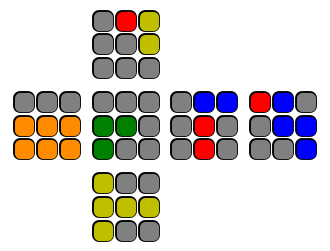

r2 U' r R2 U' r' U r2


In [11]:
cube = Cube(mode)
sol = "U' r' U2 r U2 R' U' R r' U' R U M'"
inv = inverse_alg(sol)
# inv = inverse_alg(inv)
print(inv)
cube.apply_moves(inv)
cube.plot()
sol = generic_solver(inv, mode, search_algs_RBD, table_RBD, string_alg = True)
print(sol)

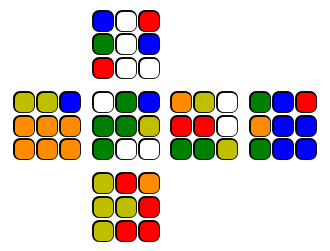

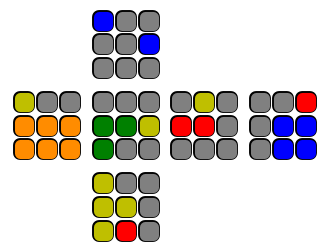

r' R U' r R U2 R


In [17]:
def generic_solver(scramble, mode, search_algs, table, string_alg = False):
    cube = Cube(mode)
    if type(scramble) == str:
        cube.apply_moves(scramble)
        cube.plot()
    else:
        cube.apply_int_moves(scramble)
    for search_alg in search_algs:
        cube.apply_int_moves(search_alg)
        ID = id_from_state(cube.state)
        if ID in table:
            if string_alg:
                return array_to_alg(cancel_alg_arrays(search_alg, table[ID][0]))
            return cancel_alg_arrays(search_alg, table[ID][0])
        cube.apply_int_moves(invert_alg_array(search_alg))
    return None


scr = "z y' D' F' U B2 D' L2 D2 B2 L2 D B2 L2 U L' R' F' R' B L' D L2 x' R' F2 U F' U' R' u"
cube = Cube()
cube.apply_moves(scr)
cube.plot()
sol = generic_solver(scr, mode, search_algs_RBD, table_RBD, string_alg = True)
print(sol)

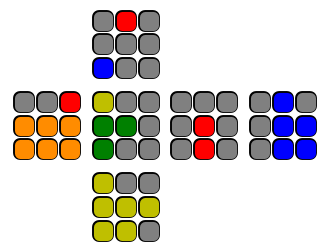

"R' U r' U' R U r U R"

In [11]:
scramble = "u R U2 R' u' R' U2 R"
# scramble = inverse_alg(scramble)
cube = Cube(mode)
cube.apply_moves(scramble)
cube.plot()
CP_solver(scramble, mode, search_algs_RBD, table_RBD, string_alg = True)

In [13]:
mode = 20
search_depth = 6
table_depth = 8
search_algs_EODF, table_EODF = CP_solver_setup(mode, search_depth, table_depth, move_transition=move_transition_rRU, start_grips=np.array([1]), skip_U=True, prnt=True)

Genning search algs...
Algs of length 1 genned. Time spent: 0.00s...
Algs of length 2 genned. Time spent: 0.00s...
Algs of length 3 genned. Time spent: 0.00s...
Algs of length 4 genned. Time spent: 0.00s...
Algs of length 5 genned. Time spent: 0.01s...
Algs of length 6 genned. Time spent: 0.02s...
Algs of length 7 genned. Time spent: 0.07s...
Algs of length 8 genned. Time spent: 0.41s...
Done genning algs. Making into np array. Time spent: 0.41s
Genning table based on 735427 algs...
73542 (10.00%) algs added in 1.17 seconds...
147084 (20.00%) algs added in 2.40 seconds...
220626 (30.00%) algs added in 3.52 seconds...
294168 (40.00%) algs added in 4.63 seconds...
367710 (50.00%) algs added in 5.70 seconds...
441252 (60.00%) algs added in 6.79 seconds...
514794 (70.00%) algs added in 8.04 seconds...
588336 (80.00%) algs added in 9.27 seconds...
661878 (90.00%) algs added in 10.31 seconds...
735420 (100.00%) algs added in 11.66 seconds...
Table generated in 11.66 seconds. Size: 425919 con

In [16]:
avg_movecount = 0
N = 10
for i in range(N):
    scramble = random_scramble_from_move_transition(move_transition_scramble, length=25, grips = np.array([1]), force_start = 0, string_scramble = True)
    for sticker in [0]:#,2,6,8,9,11,15,17,18,20,24,26,27,29,33,35,36,38,42,44,45,47,51,53]:
        print(f"Scramble {i}: {scramble}, sticker: {sticker}")
        extended_scramble, ori = get_oriented_scramble(scramble, sticker)
        # first find the CPFB solution
        sol_CPFB = CP_solver(extended_scramble, 22, search_algs_CPFB, table_CPFB, string_alg = True)
        solution = sol_CPFB
        print(f"\tOrientation:", ori)
        print(f"\tCPFB: {sol_CPFB} ({len(sol_CPFB.split(' '))} moves)")
        extended_scramble += " " + sol_CPFB
        # sol_RBD = CP_solver(extended_scramble, 21, search_algs_RBD, table_RBD, string_alg = True)
        # solution += " " + sol_RBD
        # print(f"\tRBD 222: {sol_RBD} ({len(sol_RBD.split(' '))} moves)")
        # extended_scramble += " " + sol_RBD
        sol_EODF = CP_solver(extended_scramble, 20, search_algs_EODF, table_EODF, string_alg = True)
        solution += " " + sol_EODF
        print(f"\tEODF: {sol_EODF} ({len(sol_EODF.split(' '))} moves)")
        extended_scramble += " " + sol_EODF
        sol_2gen = CP_solver(extended_scramble, 0, search_algs_2gen, table_2gen, string_alg = True)
        solution += " " + sol_2gen
        print(f"\t2gen: {sol_2gen} ({len(sol_2gen.split(' '))} moves)")
        space = " " if ori else ""
        print(f"\tFull solution: {ori}{space}{solution} ({len(solution.split(' '))} moves)")
        avg_movecount += len(solution.split(" "))
avg_movecount /= (N)
print(avg_movecount)

Scramble 0: R B D' L D2 L U2 L' D L2 B' R U F2 U' D' L D2 U R L2 R2 U2 F2 B, sticker: 0
	Orientation: x' y


AttributeError: 'NoneType' object has no attribute 'split'

# EO after 223

In [53]:
move_transition_RUEO = np.array([ 
#   [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44],
    [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#   [ R,R2,R', L,L2,L', r,r2,r', l,l2,l', M,M2,M', U,U2,U', D,D2,D', u,u2,u', d,d2,d', E,E2,E', F,F2,F', B,B2,B', f,f2,f', b,b2,b', S,S2,S'],
    [ 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4], # 1. Standard
    [ 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 2. - u moves
    [ 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 3. - r moves
    [ 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4], # 4. - S moves

])

mode = 6 # 223
length = 8
categorize = True
categorize_mode = 25 # 223 + EO
full_algs = gen_full_algs(length=length, mode=mode, move_transition=move_transition_RUEO, start_grips=np.array([1]), skip_U=True, prnt=True, categorize=categorize, categorize_mode=categorize_mode, return_full_alg_list=False)
len(full_algs)

--- Initiating alg genning up to length 8 ---
Parameters:
  - mode = 6
  - start_grips = 1
  - skip_U = True
  - prnt = True
Genning search algs...
Algs of length 1 genned. Time spent: 0.00s...
Algs of length 2 genned. Time spent: 0.00s...
Algs of length 3 genned. Time spent: 0.00s...
Algs of length 4 genned. Time spent: 0.00s...
Done genning algs. Making into np array. Time spent: 0.00s
Genning table based on 4498 algs...
449 (9.98%) algs added in 0.08 seconds...
898 (19.96%) algs added in 0.14 seconds...
1347 (29.95%) algs added in 0.21 seconds...
1796 (39.93%) algs added in 0.27 seconds...
2245 (49.91%) algs added in 0.32 seconds...
2694 (59.89%) algs added in 0.37 seconds...
3143 (69.88%) algs added in 0.42 seconds...
3592 (79.86%) algs added in 0.47 seconds...
4041 (89.84%) algs added in 0.52 seconds...
4490 (99.82%) algs added in 0.56 seconds...
Table generated in 0.56 seconds. Size: 410 consisting of 2946 algs
--- Initiating search alg genning up to length 4. Previous algs canno

24

In [58]:
short_algs = {}
# for each ID, take the first 10 algs (they are already sorted by movecount)
for ID in full_algs:
    short_algs[ID] = full_algs[ID][:10]
short_algs

{'000115110000000000000533033000444444050505050660665660': ['()',
  'R2',
  "R'",
  'R',
  "R U' R",
  "R' U R'",
  "R2 U R'",
  'R U2 R2',
  "R' U2 R",
  "R U' R2"],
 '050110110000505000050033033000444444000505000660665660': ["(U') S R S'",
  "(U') S R' S'",
  "R' S' U S",
  "(U') S R S' R",
  "R' S' U' S",
  "R S' U' S",
  "(U') S R S' R2",
  "(U') S R' S' R2",
  "R S' U S",
  "(U') S R' S' R'"],
 '050115110050000050050533033000444444000500000660660660': ["S' U S",
  "S' U' S",
  "S' U' S R",
  "S' U S R",
  "S' U' S R2",
  "S' U S R2",
  "S' U' S R'",
  "S' U S R'",
  "R2 S' U S",
  "R2 S' U' S"],
 '050115110000000050000533033000444444050505000660660660': ["(U2) r' U' R' U r",
  "r U R U' r'",
  "r U R U' r' R",
  "(U2) r' R U' R2 U r",
  "R2 S' R' U R S",
  "r R' U R2 U' r'",
  "(U) R u' R' U' R u",
  "(U2) R u' R' U2 R u",
  "(U2) S' U2 R U R' S",
  "(U2) R2 S' R U' R' S"],
 '050115110050000000050533033050444444000000000660665660': ["R2 U2 S' U' S",
  "R2 U2 S' U S",
  "R2 U2 S' U

In [57]:
avg_movecount = 0
for ID in short_algs:
    avg_movecount += len(short_algs[ID][0].split(" ")) - short_algs[ID][0].count(")")
avg_movecount /= len(short_algs)
avg_movecount

4.833333333333333

Support algs imported!
Cube initiated
         5 5 5
         5 5 5
         5 5 5
4 4 4  1 1 1  2 2 2  3 3 3
4 4 4  1 1 1  2 2 2  3 3 3
4 4 4  1 1 1  2 2 2  3 3 3
         6 6 6
         6 6 6
         6 6 6



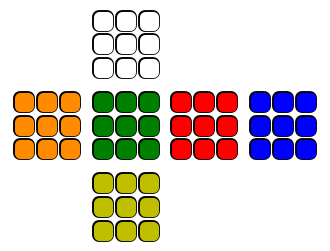

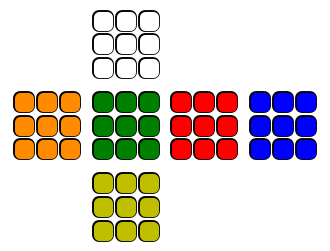

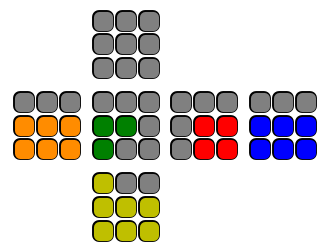

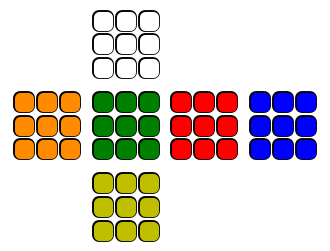

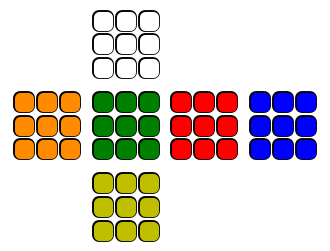

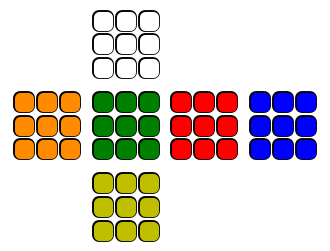

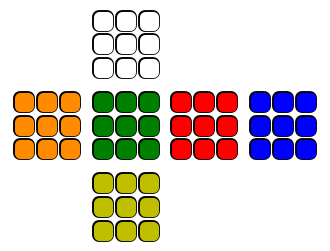

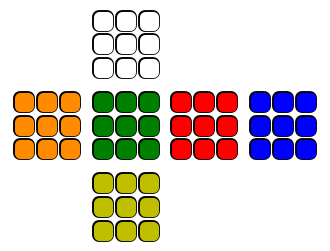

In [18]:
%run ../cube/Cube.ipynb # reload in case we changed the Cube class

print(Cube(1))

mode = 0 # normal
Cube(mode).plot()

mode = 20 # EODF
Cube(mode).plot()

mode = "FB+222RBD" # FB + 222 in BRD
Cube(mode).plot()

mode = 22 # FB
Cube(mode).plot()

mode = 23 # 113
Cube(mode).plot()

mode = 24 # D corners
Cube(mode).plot()

mode = 6 # 223
Cube(mode).plot()

mode = 25 # 223 + EO
Cube(mode).plot()
